#World cup 2018 prediction-Exploratory Data Analysis(Group 3)



In [0]:
# load different libraries useful for our work

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import requests
from io import BytesIO
from pandas.plotting import scatter_matrix
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import math
from scipy.special import gamma
from bs4 import BeautifulSoup
import bs4 as bs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from dateutil import relativedelta as rdelta
import seaborn as sns
sns.set()
from IPython.display import display
from scipy.stats import norm

#WC 2018 Participating teams and players data to be used throughout  our work<a id ='Teamdanalysis'></a> 

In [261]:
# https://en.wikipedia.org/wiki/2018_FIFA_World_Cup_squads
# scrape the squad of every nation selected to the world cup with their data and get a list of all the countries from wikipedia

my_page=requests.get("https://en.wikipedia.org/wiki/2018_FIFA_World_Cup_squads")

#Page for Champions leage Team 2017 - 2018
champions_league_page = requests.get("https://en.wikipedia.org/wiki/2017%E2%80%9318_UEFA_Champions_League_group_stage")

squad_soup = BeautifulSoup(my_page.text, "html.parser")
CL_soup = BeautifulSoup(champions_league_page.text, "html.parser") # Parse the champions league page

#GET the list of teams for CHampions LEague 2017-2018
CL_list = []
#find top_node of the teams
top_node = CL_soup.find("th", attrs={"width": "200"})

next_link = top_node.find_next('a')  # get the first link in the node
for i in range(78):  # getting through the next 78 links 
    next_link = next_link.find_next('a')  # retrieve the next link
    CL_team = next_link.text.strip('\n')  # Strip all junk character
    if CL_team and '[' not in CL_team:  # Condition to make sure that the link is an actual team 
        CL_list.append(CL_team)  # Add the team to the champions league team 

        
cup_date = datetime.datetime(2018, 7, 1, 0, 0, 0)
country_tables = squad_soup.findAll("table", attrs={"class": "sortable wikitable plainrowheaders"})
starlist = []
countrylist = []
top_league_country = ['France', 'Italy', 'Germany', 'England', 'Spain']   #List of top 5 Soccer League in the World


for country_table in country_tables:
    players = country_table.findAll("th", attrs={"scope": "row"})
        
    for name in players:
        d = dict()
        d['name'] = name.find('a').text.strip('\n')
        pos = name.find_previous_sibling()
        d['pos'] = pos.find('a').text.strip('\n').strip('()')
        rawbday = name.find_next_sibling()
        bday = datetime.datetime.strptime(rawbday.find('span',attrs={'class':'bday'}).text.strip('\n'), '%Y-%m-%d')
        age = rdelta.relativedelta(cup_date,bday).years
        
        d['age'] = age
        caps = rawbday.find_next_sibling()
        d['caps'] = caps.text.strip('\n')
        goals = caps.find_next_sibling()
        d['goals'] = goals.text.strip('\n')
        country = goals.find_previous('h3').find('span').text.strip('\n')
        club = goals.find_next('a').find_next('a').text.strip('\n')   # Retrieve the club information of the player
        if caps.find_next('a')['title'] in top_league_country:  #Check if the Club is in Top5 leagues
            top_league = 1  # If yes, CLub in Top 5 league 
        else: 
            top_league = 0  # Club isn't in top 5 league
        d['country'] = country
        d['club'] = club  # Add the club Name of the player in the DataFrame
        d['Top League'] = top_league # Add the player in Top 5 League or Not. 
        
        if club in CL_list:  # Check if the club played champions league
            CL_league = 1
        else: 
            CL_league = 0
        d['CL League 2017-2018'] = CL_league # add Champions league 2017/2018 to the data frame
        starlist.append(d)

    countrylist.append(country)
print(starlist)
print(countrylist)



[{'name': 'Essam El-Hadary', 'pos': 'GK', 'age': 45, 'caps': '158', 'goals': '0', 'country': 'Egypt', 'club': 'Al-Taawoun', 'Top League': 0, 'CL League 2017-2018': 0}, {'name': 'Ali Gabr', 'pos': 'DF', 'age': 29, 'caps': '21', 'goals': '1', 'country': 'Egypt', 'club': 'West Bromwich Albion', 'Top League': 1, 'CL League 2017-2018': 0}, {'name': 'Ahmed Elmohamady', 'pos': 'DF', 'age': 30, 'caps': '78', 'goals': '2', 'country': 'Egypt', 'club': 'Aston Villa', 'Top League': 1, 'CL League 2017-2018': 0}, {'name': 'Omar Gaber', 'pos': 'MF', 'age': 26, 'caps': '24', 'goals': '0', 'country': 'Egypt', 'club': 'Los Angeles FC', 'Top League': 0, 'CL League 2017-2018': 0}, {'name': 'Sam Morsy', 'pos': 'MF', 'age': 26, 'caps': '5', 'goals': '0', 'country': 'Egypt', 'club': 'Wigan Athletic', 'Top League': 1, 'CL League 2017-2018': 0}, {'name': 'Ahmed Hegazi', 'pos': 'DF', 'age': 27, 'caps': '45', 'goals': '1', 'country': 'Egypt', 'club': 'West Bromwich Albion', 'Top League': 1, 'CL League 2017-2018'

In [262]:
# put the squad data and nations participating on a data frame to use in later analysis

# players squads in details and their respective information
df_players = pd.DataFrame(starlist)
display(df_players.head())

# All the national teams participating in the world cup- used frequently throughout our worl
df_countries = pd.DataFrame(countrylist,columns = ['Nations Participating'])
display(df_countries.head())

cup2018_players = df_players['name']

list_of_players=df_players['name']

,CL League 2017-2018,Top League,age,caps,club,country,goals,name,pos
0,0,0,45,158,Al-Taawoun,Egypt,0,Essam El-Hadary,GK
1,0,1,29,21,West Bromwich Albion,Egypt,1,Ali Gabr,DF
2,0,1,30,78,Aston Villa,Egypt,2,Ahmed Elmohamady,DF
3,0,0,26,24,Los Angeles FC,Egypt,0,Omar Gaber,MF
4,0,1,26,5,Wigan Athletic,Egypt,0,Sam Morsy,MF


,Nations Participating
0,Egypt
1,Russia
2,Saudi Arabia
3,Uruguay
4,Iran


#Squad data averaged and summed

In [263]:
# make a pivot table of the averages of all the squads  ages caps and goals and sum the other columns
df_players['caps'] = pd.to_numeric(df_players['caps'])
df_players['goals'] = pd.to_numeric(df_players['goals'])
players_features = pd.pivot_table(df_players,index='country',values=['age','caps','Top League','CL League 2017-2018','goals'], aggfunc={'age':'mean','caps':'mean','Top League':'sum','CL League 2017-2018':'sum','goals':'sum'}) # 'Top League'
players_features['country']=players_features.index
players_features.head()

,CL League 2017-2018,Top League,age,caps,goals,country
country,,,,,,
Argentina,14,14,29.130435,37.347826,172,Argentina
Australia,2,9,27.608696,29.826087,121,Australia
Belgium,17,19,27.217391,47.260870,156,Belgium
Brazil,18,17,28.130435,29.869565,127,Brazil
Colombia,6,13,27.913043,31.000000,91,Colombia


#X and Y train Dataset-Cleaning preparation and creation



In [264]:
# wolrdcup1 fifa international results
response = requests.get('https://drive.google.com/uc?export=download&id=1p9aepCMiZWyA9eQYuUl3gDV51kYVqMDj')
df = pd.read_csv(BytesIO(response.content))
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [265]:
print(df.shape)
df=df.drop(["city"],axis=1)

(39638, 9)


In [266]:
df.describe()

,home_score,away_score
count,39638.000000,39638.000000
mean,1.748221,1.187749
std,1.747294,1.400002
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,31.000000,21.000000


In [267]:

# Add winnning team column and goal difference
winner=[]
for i in range(len(df['home_team'])):
  if df['home_score'][i] > df['away_score'][i]:
    winner.append(df['home_team'][i])
  elif df['home_score'][i] < df['away_score'][i]:
    winner.append(df['away_team'][i])
  else:
    winner.append('Draw')
df['winning_team']=winner
df['goal_difference']=np.absolute(df['home_score']-df['away_score'])
df.head()


,date,home_team,away_team,home_score,away_score,tournament,country,neutral,winning_team,goal_difference
0,1872-11-30,Scotland,England,0,0,Friendly,Scotland,False,Draw,0
1,1873-03-08,England,Scotland,4,2,Friendly,England,False,England,2
2,1874-03-07,Scotland,England,2,1,Friendly,Scotland,False,Scotland,1
3,1875-03-06,England,Scotland,2,2,Friendly,England,False,Draw,0
4,1876-03-04,Scotland,England,3,0,Friendly,Scotland,False,Scotland,3


In [268]:
# get all historical matches of the countries participating in 2018 world cup

df_natteam_home=df[df['home_team'].isin(countrylist)]
df_natteam_away=df[df['away_team'].isin(countrylist)]
df=pd.concat((df_natteam_home,df_natteam_away))
# df.drop_duplicates()
display(df.shape)
df.head()

(20375, 10)

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,winning_team,goal_difference
1,1873-03-08,England,Scotland,4,2,Friendly,England,False,England,2
3,1875-03-06,England,Scotland,2,2,Friendly,England,False,Draw,0
6,1877-03-03,England,Scotland,1,3,Friendly,England,False,Scotland,2
10,1879-01-18,England,Wales,2,1,Friendly,England,False,England,1
11,1879-04-05,England,Scotland,5,4,Friendly,England,False,England,1


In [269]:
# get all international matches of the teams of the world cup since 1990
year=[]
for n in df['date']:
  year.append(int(n[:4]))
df['match_year']=year

display(df.head())


,date,home_team,away_team,home_score,away_score,tournament,country,neutral,winning_team,goal_difference,match_year
1,1873-03-08,England,Scotland,4,2,Friendly,England,False,England,2,1873
3,1875-03-06,England,Scotland,2,2,Friendly,England,False,Draw,0,1875
6,1877-03-03,England,Scotland,1,3,Friendly,England,False,Scotland,2,1877
10,1879-01-18,England,Wales,2,1,Friendly,England,False,England,1,1879
11,1879-04-05,England,Scotland,5,4,Friendly,England,False,England,1,1879


In [270]:
df.shape

(20375, 11)

In [271]:
df=df[df.match_year>=1990]
display(df.head())
display(df.shape)

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,winning_team,goal_difference,match_year
15795,1990-01-17,Mexico,Argentina,2,0,Friendly,USA,True,Mexico,2,1990
15802,1990-01-24,France,German DR,3,0,Friendly,Kuwait,True,France,3,1990
15804,1990-01-25,Nigeria,Ivory Coast,2,0,Friendly,Nigeria,False,Nigeria,2,1990
15809,1990-01-28,Nigeria,Senegal,1,1,Friendly,Nigeria,False,Draw,0,1990
15811,1990-02-02,Colombia,Uruguay,0,2,Friendly,USA,True,Uruguay,2,1990


(10580, 11)

In [272]:
df_natteam=df[df['home_team'].isin(countrylist)& df['away_team'].isin(countrylist)]
print(df_natteam.shape)
df_natteam.head()

(3564, 11)


,date,home_team,away_team,home_score,away_score,tournament,country,neutral,winning_team,goal_difference,match_year
15795,1990-01-17,Mexico,Argentina,2,0,Friendly,USA,True,Mexico,2,1990
15809,1990-01-28,Nigeria,Senegal,1,1,Friendly,Nigeria,False,Draw,0,1990
15811,1990-02-02,Colombia,Uruguay,0,2,Friendly,USA,True,Uruguay,2,1990
15813,1990-02-02,Iran,Poland,0,2,Friendly,Iran,False,Poland,2,1990
15816,1990-02-04,Costa Rica,Uruguay,0,2,Friendly,USA,True,Uruguay,2,1990


Text(0.5,1,'goal difference in all international matches')

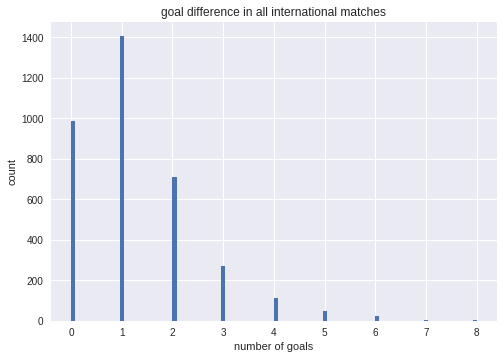

In [273]:
# Show distribution of goal differences in the international matches

# fig, axes = plt.subplots(2, 1)
plt.hist(df_natteam['goal_difference'],bins=100)
plt.xlabel("number of goals")
plt.ylabel("count")
plt.title("goal difference in all international matches")
# df.hist('h_draw',bins=100, ax=axes[0,1])

Text(0.5,0,'Number of matches')

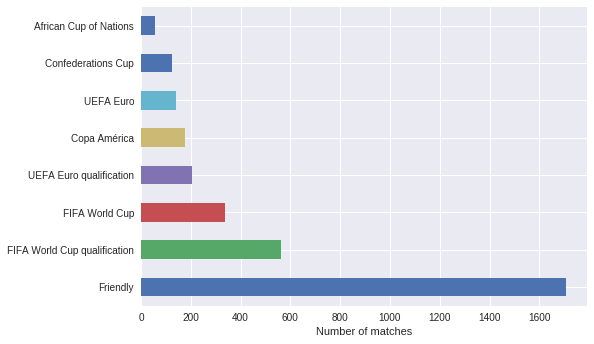

In [274]:
# Show the distribution of the most played international tournaments
df_natteam['tournament'].value_counts()[:8].plot(kind='barh')
plt.xlabel("Number of matches")

Text(0.5,1,'The 10 most successful countries in internataional matches since 1990')

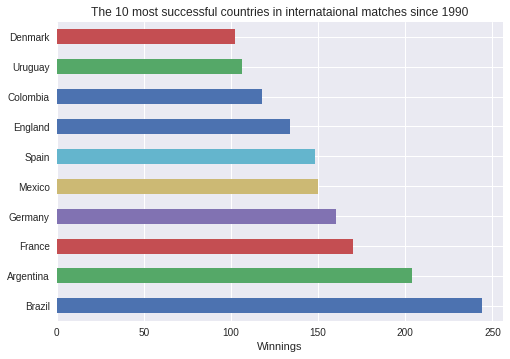

In [275]:
# show the countries with the most wins since 1990 for all these international games
df_natteam['winning_team'].value_counts()[1:11].plot(kind='barh')
plt.xlabel("Winnings")
plt.title("The 10 most successful countries in internataional matches since 1990")


Text(0.5,1,'Performance of Home Team')

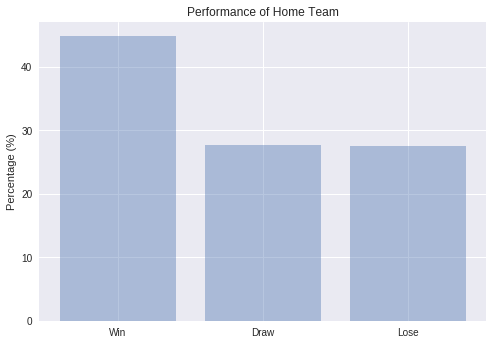

In [276]:
#examine the perfromance of the squads when they play at home
home_win = df_natteam[df_natteam.home_score > df_natteam.away_score]
away_win = df_natteam[df_natteam.home_score < df_natteam.away_score]
draw_df = df_natteam[df_natteam.home_score == df_natteam.away_score]

win=home_win.shape[0]/df_natteam.shape[0]*100
draw=draw_df.shape[0]/df_natteam.shape[0]*100
lose=(df_natteam.shape[0]-home_win.shape[0]-draw_df.shape[0])/df_natteam.shape[0]*100


objects = ('Win', 'Draw', 'Lose')
y_pos = np.arange(len(objects))
performance = [win,draw,lose]
plt.bar(y_pos, performance, align='center', alpha=0.4)
plt.xticks(y_pos, objects)
plt.ylabel('Percentage (%)')
plt.title('Performance of Home Team')

In [0]:
# Create x and y train
x_train = df_natteam[['home_team','away_team']]
y_train = df_natteam['winning_team']

#test set

In [0]:
# scrape and create our test set

fifa_page=requests.get("https://fixturedownload.com/results/fifa-world-cup-2018")
ranking_soup = BeautifulSoup(fifa_page.text, "html.parser")
match_table = ranking_soup.find('tbody')
rows_match = match_table.findAll('tr')

home_country = []
score = []
away_country = []
for row in rows_match:
    tds = row.findAll('td')
    
    home_country.append(tds[3].text)
    
    away_country.append(tds[4].text)
    
    score.append(tds[6].text)

In [279]:
winner = []
k = 0
for value in score:
    game_result = value.split(' ')
    if int(game_result[0]) > int(game_result[-1]):
        winner.append(home_country[k])
    elif int(game_result[0]) == int(game_result[-1]):
        winner.append('Draw')
    else:
        winner.append(away_country[k])
    k +=1

df = pd.DataFrame({'home_team':home_country,'away_team':away_country,'winning_team':winner})
display(df.head())

x_test = df[['home_team','away_team']]
y_test = df['winning_team']

,away_team,home_team,winning_team
0,Saudi Arabia,Russia,Russia
1,Uruguay,Egypt,Uruguay
2,Iran,Morocco,Iran
3,Spain,Portugal,Draw
4,Australia,France,France


#Feature engineering for our baseline model

###FIFA rankings- the most important feature of our baseline model

In [280]:
# scrape the Fifa rankings from the fifa.com website as of the seventh of june 2018- Just before the world cup started
# https://www.fifa.com/fifa-world-ranking/ranking-table/men/rank/id12210/#all



fifa_page=requests.get("https://www.fifa.com/fifa-world-ranking/ranking-table/men/rank/id12210/#all")

ranking_soup = BeautifulSoup(fifa_page.text, "html.parser")

    
ranking_table = ranking_soup.findAll("tbody")

ranking_list=[]

# rankings= ranking_tables.find_all("span",attrs={'class':"fi-t__nText "})


# ranking_tables

# div class="fi-t__n"
        
for rank in ranking_table:
  ranked_countries = rank.findAll('tr')
  
  for c in ranked_countries:
    di = dict()
    
    ranking = c.find('td',attrs={'class':"fi-table__td fi-table__rank"}).text
    di['ranking'] = ranking
    di['country_ranked_06/18']=c.find('a',attrs={'class':"fi-t__link"}).find('span',attrs={'class':"fi-t__nText"}).text
    ranking_list.append(di)
raw_df_ranking = pd.DataFrame(ranking_list)
#south korea and Iran doesn't apear in the same name in ranking and country list
raw_df_ranking = raw_df_ranking.replace({"Korea Republic":"South Korea","IR Iran":"Iran"})

df_ranking=raw_df_ranking[raw_df_ranking['country_ranked_06/18'].isin(countrylist)]


df_ranking['ranking'] = pd.to_numeric(df_ranking['ranking'])
df_ranking.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,country_ranked_06/18,ranking
0,Germany,1
1,Brazil,2
2,Belgium,3
3,Portugal,4
4,Argentina,5


In [281]:
#get the rankings of only the squads that participated in the 2018 world cup
df_ranking=df_ranking[df_ranking['country_ranked_06/18'].isin(countrylist)]

df_ranking.set_index("country_ranked_06/18")
df_ranking = df_ranking.rename(columns={'country_ranked_06/18': 'country'})
df_ranking.set_index('country')
df_ranking.head()

,country,ranking
0,Germany,1
1,Brazil,2
2,Belgium,3
3,Portugal,4
4,Argentina,5


#### Feature of the last 20 matches performance before the world cup

In [282]:
# get the 20 most recent performance and later make it a predictor
winning_teamlist = df['winning_team'].unique()

number_wins = []
for team in countrylist:
    index_played = df[(df['home_team']==team) | (df['away_team']==team)][-20:]
    won_games = index_played[index_played['winning_team']==team].shape[0]
    number_wins.append({'country':team,'# won':won_games})

df_wins = pd.DataFrame(number_wins)
df_wins.set_index('country').head()

,# won
country,
Egypt,0
Russia,2
Saudi Arabia,1
Uruguay,4
Iran,1


#### National squd Coach salary feature

In [0]:
# Function to get the Original Country of Coach and his/her age 
import datetime 
import time
now = datetime.datetime.now()  # Import the datetime  library 

def coach_info(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, "html.parser")  # Parse the passed URL 
    
    
    nodes = soup.select('div.fi-p__profile-text--uppercase')  # Select the div necessary for scrapping values
    age = now.year - int(nodes[0].find('span').text.strip()[-4:])  # Extract the age of the coach 
    nationality = nodes[1].find('span').text.strip()  # extract the nationality of the coach 
    return (age, nationality)

In [0]:
# Get the list for all coaches for the world cup, their age, original country 


ROOT = "https://www.fifa.com"

coach_page=requests.get("https://www.fifa.com/worldcup/players/coaches/") # Get URL from the coaches list
coach_soup = BeautifulSoup(coach_page.text, "html.parser") # Parse the page.text in Beautiful Soup

salary_page = requests.get("http://www.footballwood.in/salary-every-coach-in-2018-fifa-world-cup.html") # URL to get salary for coaches
salary_soup = BeautifulSoup(salary_page.text, "html.parser")

# Get list of coaches salary and their country 
coach_dict = {}
salary_nodes = salary_soup.findAll('tr')
for i in range(1,len(salary_nodes)):
    pays = salary_nodes[i].findNext('td').findNext('td').findNext('td').text
    if pays == 'Iran': pays = 'IR Iran'
    if pays == 'South Korea': pays = 'Korea Republic'
    salaire = salary_nodes[i].findNext('td').findNext('td').findNext('td').findNext('td').text.strip('£')   
    if salaire[-1] == 'm': 
        salary = float(salaire.strip('m')) * 1000000
    else:
        salary = float(salaire.replace(',', ''))
    coach_dict[pays] = salary
 
    
#ranking_table = ranking_soup.findAll("tbody")

def parse_coach (soup: BeautifulSoup):
    
    coachlist = []  #List to save the coaches
    teamlist = []  #list of save the team
    
    coach_nodes = soup.select('div.fi-p__name')   # Narrow to div containing the coach names
    team_nodes = soup.select('div.fi-p__country') # Narrow to div contaning the coach's team 
    detail_nodes = soup.select('div.col-sm-3')    # Get the href for the Coach information
    for i in range(len(coach_nodes)):
        dictionaire = {}  # dictionaire to save the coach and the team he/she corresponds to
        dictionaire['country'] = team_nodes[i].text.strip() # Get the country name for the coach 
        dictionaire['coach'] = coach_nodes[i].text.strip() # Get the coach corresponding to the country
        dictionaire['coach age'], dictionaire['nationality'] = coach_info(ROOT+detail_nodes[i].find('a').attrs['href']) # Get age and nationality of the coach 
        dictionaire['Coach Salary'] = coach_dict[team_nodes[i].text.strip()]
#         time.sleep(2)
        coachlist.append(dictionaire)
        
    return coachlist

In [285]:
df_coaches = pd.DataFrame(parse_coach(coach_soup))  # Convert coach list into dataframe
df_coaches['country'] = df_coaches.country.replace({"Korea Republic":"South Korea","IR Iran":"Iran"})
df_coaches.head()

,Coach Salary,coach,coach age,country,nationality
0,235600.0,Adam NAWALKA,61,Poland,POL
1,810000.0,Age HAREIDE,65,Denmark,NOR
2,810000.0,Akira NISHINO,63,Japan,JPN
3,174500.0,Aliou CISSE,42,Senegal,SEN
4,1030000.0,Bert VAN MARWIJK,66,Australia,NED


### For our base line model an extra 3 features were used(taken from players_features dataframe above): average age of every team, average number of caps and average number of goals

##Features DataFrame for the baseline model

In [286]:
#Data set with Few predictor focused on Fifa Ranking 
result3 = pd.merge(df_wins, players_features, on='country')
result3 = pd.merge(result3,df_ranking, on='country')
result3 = pd.merge(result3,df_coaches, on='country')
result3 = result3.set_index('country')
# drop unnecessary columns
result3=result3.drop(["Top League","nationality","CL League 2017-2018", "coach", "coach age"],axis=1)
display(result3.head())


,# won,age,caps,goals,ranking,Coach Salary
country,,,,,,
Egypt,0,28.521739,37.304348,64,45,1300000.0
Russia,2,28.304348,28.521739,56,70,2210000.0
Saudi Arabia,1,28.173913,34.304348,91,67,1230000.0
Uruguay,4,27.782609,42.260870,134,14,1470000.0
Iran,1,26.739130,30.521739,109,37,1690000.0


In [287]:
# standardize the features data frame because of differences in values scale
result3 = (result3-result3.mean())/result3.std()
result3.head()

,# won,age,caps,goals,ranking,Coach Salary
country,,,,,,
Egypt,-0.973409,1.032079,0.200949,-0.975293,0.953167,0.164699
Russia,0.272555,0.818454,-0.685091,-1.170963,2.171272,1.194555
Saudi Arabia,-0.350427,0.690278,-0.101708,-0.314906,2.025099,0.085479
Uruguay,1.518518,0.305752,0.700991,0.736820,-0.557283,0.357090
Iran,-0.350427,-0.719652,-0.483319,0.125351,0.563373,0.606066


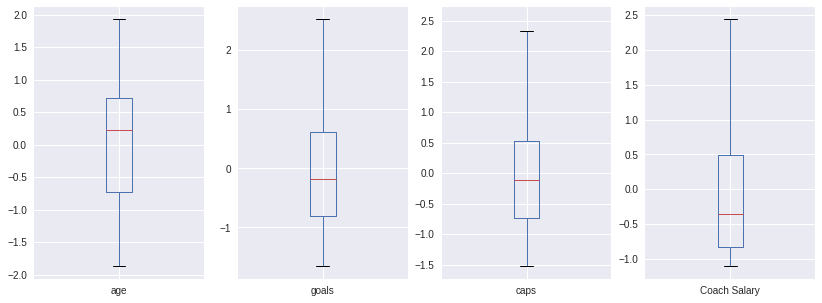

In [288]:

plt.figure(figsize = [14,5])
plt.subplot(1,4,1)
bplot1=result3.boxplot(column=['age'],figsize=(2,4),
                       grid=True)
plt.subplot(1,4,2)
bplot2=result3.boxplot(column=['goals'],figsize=(2,4),
                       grid=True)
plt.subplot(1,4,3)
bplot3=result3.boxplot(column=['caps'],figsize=(2,4),
                       grid=True)
plt.subplot(1,4,4)
bplot4=result3.boxplot(column=['Coach Salary'],figsize=(2,4),
                       grid=True)



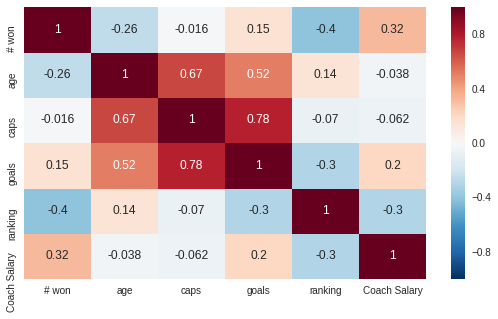

In [289]:
plt.figure(figsize=(9,5))
sns.heatmap(result3.corr(),annot=True) 

#Results of our basline model

In [0]:
# function used  in order to merge the x and y_train sets with the features data frame and then give it to the model

def prepare_data(x_train,y_train,result):

    x1 = np.array(result.loc[x_train['home_team']])   # Match each home team game to it's stats 
    x2 = np.array(result.loc[x_train['away_team']])   # Match each away team game to its stats
    y = np.zeros_like(y_train.values)
    y[y_train.values == 'Draw'] = 0   #Build the classfication
    y[y_train.values == x_train['home_team'].values] = 1
    y[y_train.values == x_train['away_team'].values] = 2
    y = np.array(y,dtype=np.float64)
    x = np.hstack((x1,x2))     # Overall dataset made of 68 predictors. 34 of the same for each team
    return x,y
  
   # fit the logistic regression model
reg = LogisticRegression(penalty='l2',multi_class='multinomial',solver='newton-cg', random_state=123)
x,y = prepare_data(x_train,y_train,result3)

In [0]:
# function to get the observed versus predicted values
def encoder(ypred,y_train,x_train):
    ypred_label = list()
    k = 0
    for y in ypred:
        if y == 1:
            ypred_label.append(x_train['home_team'].values[k])
        elif y == 0:
            ypred_label.append('Draw')
        else:
            ypred_label.append(x_train['away_team'].values[k])
        k += 1
    return pd.DataFrame({'Predicted':ypred_label,'Observed':y_train.values})

In [0]:
# function used in order to get the a confusion matrix of the classifcation model used
def confusion_matrix_model(model_used):
    cm=confusion_matrix(y,model_used.predict(x))
    col=["Predicted Away Win","Predicted Draw","Predicted Home Win"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Away Win","Predicted Draw","Predicted Home Win"]
    cm.index=["Actual Away Win","Actual Draw","Actual Home Win"]
    return cm.T


##Logisitic regression-Baseline model

In [293]:
# fit the logistic regression model
reg3 = LogisticRegression(penalty='l2',multi_class='multinomial', solver='newton-cg', random_state=123)
x,y = prepare_data(x_train,y_train,result3)
mm3 = pd.DataFrame(x)
reg3.fit(x,y)
ypredml1 = reg3.predict(x)
# df_predml1 = encoder(ypredml1,y_train,x_train)
# display(df_predml1.head())
df_pred_mat_lr = confusion_matrix_model(reg3)
display("conf matrix of logisitic regression",df_pred_mat_lr) 
print("accuracy score or the model logistic regression multinomial model is:",accuracy_score(ypredml1,y))

'conf matrix of logisitic regression'

,Actual Away Win,Actual Draw,Actual Home Win
Predicted Away Win,50,30,42
Predicted Draw,594,1320,478
Predicted Home Win,342,248,460


accuracy score or the model logistic regression multinomial model is: 0.5134680134680135


##KNN-baseline model

In [294]:
# fit knn
KNN3=KNeighborsClassifier(n_neighbors=12,p=1,weights='uniform')
KNN3.fit(x,y)
#make predictions
ypredml3 = KNN3.predict(x)
#use confusion matrix function
df_pred_mat_knn = confusion_matrix_model(KNN3)
display("conf matrix of the KNN model",df_pred_mat_knn)  
print("accuracy score of the knn model:",accuracy_score(ypredml3,y))  

'conf matrix of the KNN model'

,Actual Away Win,Actual Draw,Actual Home Win
Predicted Away Win,520,282,226
Predicted Draw,334,1224,340
Predicted Home Win,132,92,414


accuracy score of the knn model: 0.6054994388327721


## Random Forest- baseline model

In [295]:
# fit the random forest model and get its accuracy score
rfml = RandomForestClassifier(n_estimators=50, oob_score=True, max_depth=10,random_state=1234)
rfml.fit(x, y)
ypredml2=rfml.predict(x)

print("accuracy score for the random forest model:",accuracy_score(ypredml2,y))


accuracy score for the random forest model: 0.6728395061728395


### Coefficient analysis-Logistic regression

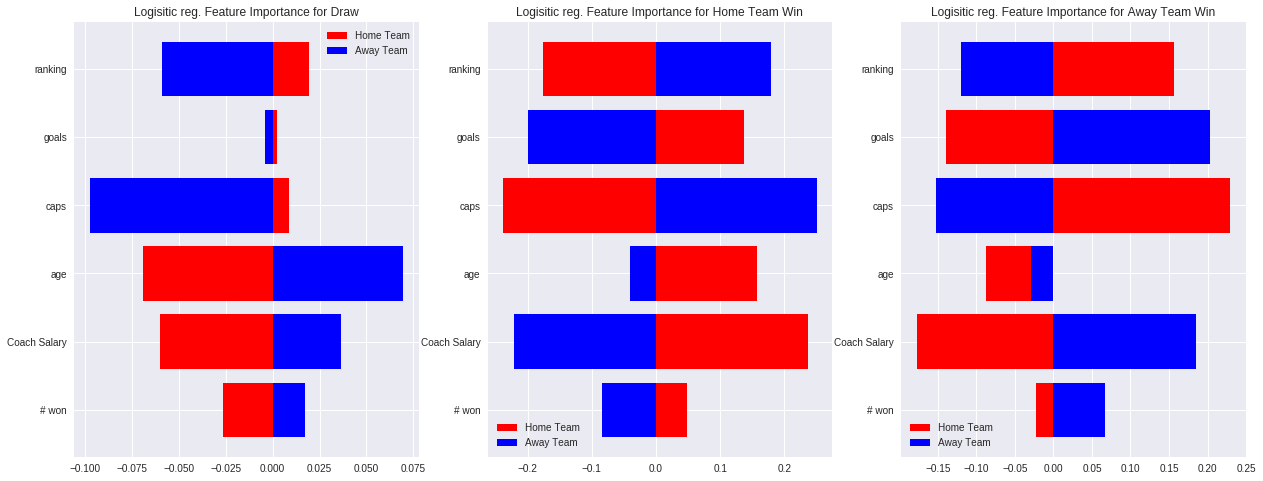

In [296]:
plt.figure(figsize = [21,8])
plt.subplot(1,3,1)
plt.title('Logisitic reg. Feature Importance for Draw')
plt.barh(result3.columns,reg3.coef_[0,:6],color='r')
plt.barh(result3.columns,reg3.coef_[0,6:],color='b')
plt.legend(['Home Team','Away Team'])
plt.subplot(1,3,2)
plt.title('Logisitic reg. Feature Importance for Home Team Win')
plt.barh(result3.columns,reg3.coef_[1,:6],color='r')
plt.barh(result3.columns,reg3.coef_[1,6:],color='b')
plt.legend(['Home Team','Away Team'])
plt.subplot(1,3,3)
plt.title('Logisitic reg. Feature Importance for Away Team Win')
plt.barh(result3.columns,reg3.coef_[2,:6],color='r')
plt.barh(result3.columns,reg3.coef_[2,6:],color='b')
plt.legend(['Home Team','Away Team'])


<Container object of 1 artists>

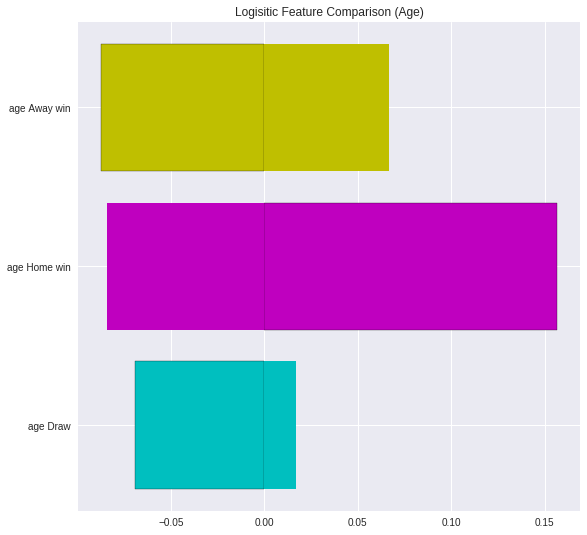

In [297]:
# result3 coefficients

plt.figure(figsize = [9,9])
plt.title('Logisitic Feature Comparison (Age)')
plt.barh(result3.columns[1]+' Draw',reg3.coef_[0,1],color='c',edgecolor='k')
plt.barh(result3.columns[1]+' Draw',reg3.coef_[0,6],color='c')
plt.barh(result3.columns[1]+' Home win',reg3.coef_[1,1],color='m',edgecolor='k')
plt.barh(result3.columns[1]+' Home win',reg3.coef_[1,6],color='m')
plt.barh(result3.columns[1]+' Away win',reg3.coef_[2,1],color='y',edgecolor='k')
plt.barh(result3.columns[1]+' Away win',reg3.coef_[2,6],color='y')


#Our model built from scratch


In [459]:
# sofifa complete dataset
response = requests.get('https://drive.google.com/uc?export=download&id=12Km8bbBwLulQi2uFymPSCkXBTB5Ws-qj')
#have to decode the bytes before it can be read by pandas into df
df1 = pd.read_csv(BytesIO(response.content),index_col=0)
df1.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,€95.5M,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€105M,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,€123M,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€97M,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,€61M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [460]:
# rank players according to their overall score
df1.nlargest(100, columns='Overall').head()

,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,€95.5M,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€105M,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,€123M,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€97M,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,€61M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# clean unnecessary columns and strip the value and wage column from non numeric signs to make the data analyzable
df1_clean=df1.drop(["Photo","Flag","Club Logo"],axis=1)
df1_clean['Value'] = df1_clean['Value'].str.replace('€', '')
df1_clean['Wage']=df1_clean['Wage'].str.replace('€','')

#parse string for millions and thousands to numeric values
def parseValueColumn(strVal):
    if 'M' in strVal:
        return int(float(strVal.replace('M', '')) * 1000000)
    elif 'K' in strVal:
        return int(float(strVal.replace('K', '')) * 1000)
    else:
        return int(strVal)   
#parse string for thousands to numeric values 
def parseWageColumn(strVal):
  if 'K' in strVal:
    return int(float(strVal.replace('K', '')) * 1000)
  else:
    return int(strVal)   
 
df1_clean['Value'] = df1_clean['Value'].apply(lambda x: parseValueColumn(x))
df1_clean['Wage']=df1_clean['Wage'].apply(lambda x: parseWageColumn(x))

In [462]:
# check for null data

df1.isnull().sum()

Name                      0
Age                       0
Photo                     0
Nationality               0
Flag                      0
Overall                   0
Potential                 0
Club                    248
Club Logo                 0
Value                     0
Wage                      0
Special                   0
Acceleration              0
Aggression                0
Agility                   0
Balance                   0
Ball control              0
Composure                 0
Crossing                  0
Curve                     0
Dribbling                 0
Finishing                 0
Free kick accuracy        0
GK diving                 0
GK handling               0
GK kicking                0
GK positioning            0
GK reflexes               0
Heading accuracy          0
Interceptions             0
                       ... 
Vision                    0
Volleys                   0
CAM                    2029
CB                     2029
CDM                 

In [463]:
df1_clean.head()

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Acceleration,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,95500000,565000,2228,89,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,L. Messi,30,Argentina,93,93,FC Barcelona,105000000,565000,2154,92,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,Neymar,25,Brazil,92,94,Paris Saint-Germain,123000000,280000,2100,94,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,L. Suárez,30,Uruguay,92,92,FC Barcelona,97000000,510000,2291,88,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,M. Neuer,31,Germany,92,92,FC Bayern Munich,61000000,230000,1493,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [464]:
df1_clean.columns

Index(['Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value',
       'Wage', 'Special', 'Acceleration', 'Aggression', 'Agility', 'Balance',
       'Ball control', 'Composure', 'Crossing', 'Curve', 'Dribbling',
       'Finishing', 'Free kick accuracy', 'GK diving', 'GK handling',
       'GK kicking', 'GK positioning', 'GK reflexes', 'Heading accuracy',
       'Interceptions', 'Jumping', 'Long passing', 'Long shots', 'Marking',
       'Penalties', 'Positioning', 'Reactions', 'Short passing', 'Shot power',
       'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle',
       'Strength', 'Vision', 'Volleys', 'CAM', 'CB', 'CDM', 'CF', 'CM', 'ID',
       'LAM', 'LB', 'LCB', 'LCM', 'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB',
       'Preferred Positions', 'RAM', 'RB', 'RCB', 'RCM', 'RDM', 'RF', 'RM',
       'RS', 'RW', 'RWB', 'ST'],
      dtype='object')

In [465]:
# limit the players for only the players in the world cup
df1_clean=df1_clean[df1_clean['Nationality'].isin(countrylist)]
display(df1_clean.shape)
df1_clean.columns
df1_clean.dtypes

(11686, 71)

Name                    object
Age                      int64
Nationality             object
Overall                  int64
Potential                int64
Club                    object
Value                    int64
Wage                     int64
Special                  int64
Acceleration            object
Aggression              object
Agility                 object
Balance                 object
Ball control            object
Composure               object
Crossing                object
Curve                   object
Dribbling               object
Finishing               object
Free kick accuracy      object
GK diving               object
GK handling             object
GK kicking              object
GK positioning          object
GK reflexes             object
Heading accuracy        object
Interceptions           object
Jumping                 object
Long passing            object
Long shots              object
                        ...   
Vision                  object
Volleys 

Text(0,0.5,'Count')

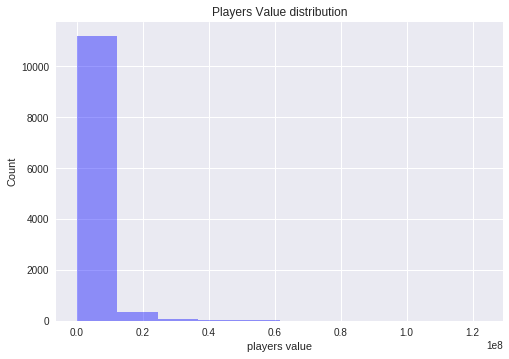

In [467]:
# show players value distribution
plt.hist(df1_clean['Value'], bins=10, alpha=0.4, color='b')
plt.title("Players Value distribution")
plt.xlabel("players value")
plt.ylabel("Count")

#Analysis of our own model's full features dataframe

In [0]:
# change object type data to integer for pivot table and fill 0 in string values
df1_clean.iloc[:,9:43]=df1_clean.iloc[:,9:43].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

In [487]:
players_pivot = pd.pivot_table(df1_clean,index='Nationality', aggfunc='mean')
players_pivot['country'] = players_pivot.index
players_pivot.head()

,Acceleration,Age,Aggression,Agility,Balance,Ball control,CAM,CB,CDM,CF,...,Special,Sprint speed,Stamina,Standing tackle,Strength,Value,Vision,Volleys,Wage,country
Nationality,,,,,,,,,,,,,,,,,,,,,
Argentina,64.584456,25.932642,55.247668,63.623834,64.943005,58.800000,60.710465,55.486047,57.126744,60.563953,...,1620.636269,64.580311,63.014508,46.212435,64.113990,2.908699e+06,53.920207,44.503627,12752.331606,Argentina
Australia,64.303965,24.312775,53.154185,61.814978,62.607930,52.779736,55.578680,54.482234,54.989848,55.223350,...,1515.881057,65.105727,61.832599,47.422907,64.894273,7.339868e+05,50.101322,37.660793,4114.537445,Australia
Belgium,63.319853,23.893382,54.444853,63.908088,63.404412,59.705882,61.982684,56.043290,58.480519,61.411255,...,1619.849265,63.856618,61.088235,45.474265,63.783088,4.450092e+06,54.628676,44.919118,19194.852941,Belgium
Brazil,66.439655,27.208128,59.816502,65.306650,64.038177,63.248768,63.122340,58.454787,60.143617,63.029255,...,1710.948276,66.811576,65.019704,50.869458,67.185961,4.008898e+06,57.556650,49.998768,18736.453202,Brazil
Colombia,66.429054,25.388514,53.596284,64.327703,64.927365,57.097973,58.020408,54.352505,55.458256,57.873840,...,1571.844595,66.322635,65.275338,46.072635,65.403716,1.708860e+06,51.471284,40.246622,5859.797297,Colombia


In [489]:
# this dataframe englobes all the predictors that make our own model

result2 = pd.merge(df_wins, players_pivot, on='country')
result2 = pd.merge(result2,df_ranking, on='country')
result2 = result2.set_index('country')
# drop the rankings and id columns
result2=result2.drop(['ranking','ID'], axis=1)
result2.head()

,# won,Acceleration,Age,Aggression,Agility,Balance,Ball control,CAM,CB,CDM,...,Sliding tackle,Special,Sprint speed,Stamina,Standing tackle,Strength,Value,Vision,Volleys,Wage
country,,,,,,,,,,,,,,,,,,,,,
Egypt,0,66.562500,27.250000,59.187500,64.906250,66.468750,61.718750,62.620690,58.551724,60.241379,...,49.218750,1681.656250,64.843750,65.125000,51.750000,69.437500,2.958437e+06,56.875000,47.937500,16062.500000
Russia,2,62.169935,25.232026,52.862745,60.238562,61.692810,54.127451,59.816000,57.020000,58.032000,...,46.519608,1567.967320,61.130719,58.555556,46.627451,62.944444,2.006209e+06,51.111111,41.415033,16637.254902
Saudi Arabia,1,63.793313,25.252280,51.954407,62.747720,65.243161,50.693009,54.134752,52.198582,52.755319,...,42.726444,1477.294833,63.942249,61.060790,43.650456,62.358663,5.641641e+05,47.890578,36.796353,6990.881459
Uruguay,4,65.196078,26.124183,57.660131,62.333333,64.287582,60.836601,61.507246,56.028986,57.550725,...,44.941176,1654.535948,65.633987,63.464052,47.437908,65.980392,4.146046e+06,52.588235,46.594771,17333.333333
Iran,1,66.764706,24.882353,57.058824,65.470588,62.941176,57.117647,64.142857,53.142857,55.571429,...,38.058824,1616.529412,67.352941,59.000000,39.411765,64.647059,2.822353e+06,58.176471,50.764706,9117.647059


In [490]:
# Standardize the feature dataset

result2 = (result2-result2.mean())/result2.std()
result2.head()

,# won,Acceleration,Age,Aggression,Agility,Balance,Ball control,CAM,CB,CDM,...,Sliding tackle,Special,Sprint speed,Stamina,Standing tackle,Strength,Value,Vision,Volleys,Wage
country,,,,,,,,,,,,,,,,,,,,,
Egypt,-1.004443,0.580573,2.014056,0.728693,0.585247,1.119629,0.827831,1.021048,1.352237,1.449602,...,1.399150,1.103102,-0.070878,0.864880,1.580004,1.275857,0.293503,1.155306,0.899396,0.688396
Russia,0.241066,-0.960402,-0.045235,-1.064121,-1.341332,-0.813308,-1.098185,0.010497,0.642664,0.461903,...,0.413839,-0.651985,-1.358004,-2.055874,-0.184286,-0.927043,-0.437585,-0.631952,-0.724445,0.794173
Saudi Arabia,-0.381688,-0.390898,-0.024566,-1.321598,-0.305682,0.623604,-1.969550,-2.036500,-1.590863,-1.897026,...,-0.970841,-2.051753,-0.383385,-0.942055,-1.209612,-1.125781,-1.544736,-1.630570,-1.874317,-0.981126
Uruguay,1.486575,0.101213,0.865189,0.295745,-0.476719,0.236858,0.604018,0.619866,0.183575,0.246750,...,-0.162361,0.684429,0.203058,0.126428,0.094849,0.102964,1.205307,-0.173927,0.565109,0.922278
Iran,-0.381688,0.651509,-0.402067,0.125299,0.818177,-0.308064,-0.339532,1.569496,-1.153426,-0.638090,...,-2.674737,0.097698,0.798935,-1.858276,-2.669487,-0.349396,0.189022,1.558865,1.603261,-0.589721


# Results of our own model

##Logistic regression- Our own model

In [492]:
# fit the logistic regression model
reg2 = LogisticRegression(penalty='l2',multi_class='multinomial',solver='lbfgs',random_state=123456)
x,y = prepare_data(x_train,y_train,result2)
mt = pd.DataFrame(x)
# scatter_matrix(mt)
# print(x.shape)
reg2.fit(x,y)
ypredmf1 = reg2.predict(x)
df_pred_full_lr = confusion_matrix_model(reg2)
display("conf matrix of logisitic regression of our model",df_pred_full_lr) 
print("accuracy score or the model logistic regression multinomial model is:",accuracy_score(ypredmf1,y))


'conf matrix of logisitic regression of our model'

,Actual Away Win,Actual Draw,Actual Home Win
Predicted Away Win,152,78,106
Predicted Draw,570,1338,412
Predicted Home Win,264,182,462


accuracy score or the model logistic regression multinomial model is: 0.547699214365881


## KNN model- Our own model

In [493]:
# fit knn
KNN2=KNeighborsClassifier(n_neighbors=12,p=1,weights='uniform')
x,y = prepare_data(x_train,y_train,result2)
KNN2.fit(x,y)
ypredmf3 = KNN2.predict(x)
df_pred_mat_knn = confusion_matrix_model(KNN2)
display("conf matrix of the KNN model of our model",df_pred_mat_knn)  
print("accuracy score of the knn model:",accuracy_score(ypredmf3,y))  

'conf matrix of the KNN model of our model'

,Actual Away Win,Actual Draw,Actual Home Win
Predicted Away Win,470,246,210
Predicted Draw,342,1198,296
Predicted Home Win,174,154,474


accuracy score of the knn model: 0.601010101010101


#EDA of our own model data

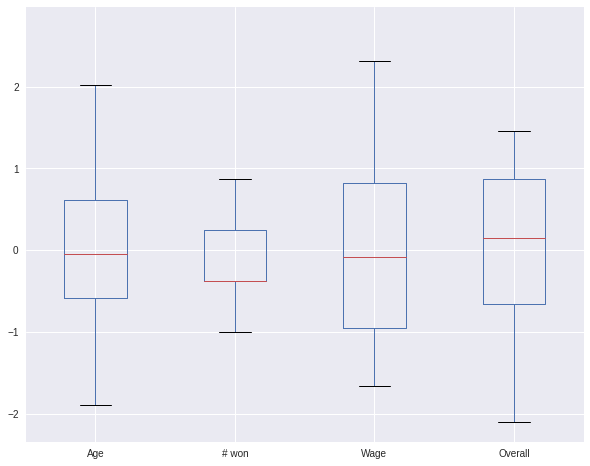

In [494]:
result2.boxplot(column=['Age','# won','Wage','Overall'],figsize=(10,8),
                       grid=True)

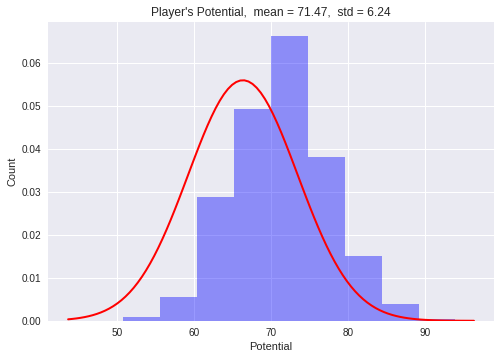

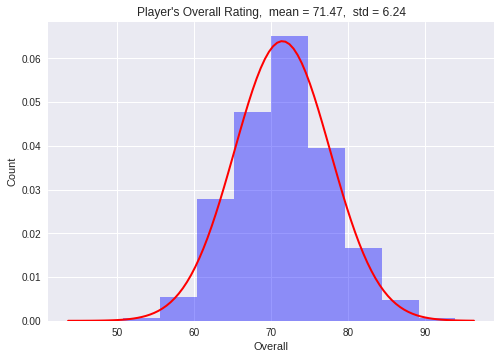

In [495]:
# show players Overall distribution
plt.hist(df1.Potential, bins=10, alpha=0.4,normed=True, color='b')
plt.title("#Players Potential distribution")
plt.xlabel("Potential")
plt.ylabel("Count")
overall_mean = df1_clean.Overall.mean()
overall_std = df1_clean.Overall.std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, overall_mean, overall_std)
plt.plot(x, p, 'k', linewidth=2, color='r')
title = "Player's Potential,  mean = %.2f,  std = %.2f" % (potential_mean, potential_std)
plt.title(title)

plt.show()



# show players Overall distribution
plt.hist(df1_clean.Potential, bins=10, alpha=0.4,normed=True, color='b')
plt.title("#Players Overall Rating distribution")
plt.xlabel("Overall")
plt.ylabel("Count")
potential_mean = df1_clean.Potential.mean()
potential_std = df1_clean.Potential.std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, potential_mean, potential_std)
plt.plot(x, p, 'k', linewidth=2, color='r')
title = "Player's Overall Rating,  mean = %.2f,  std = %.2f" % (potential_mean, potential_std)
plt.title(title)

plt.show()

Text(0,0.5,'Country')

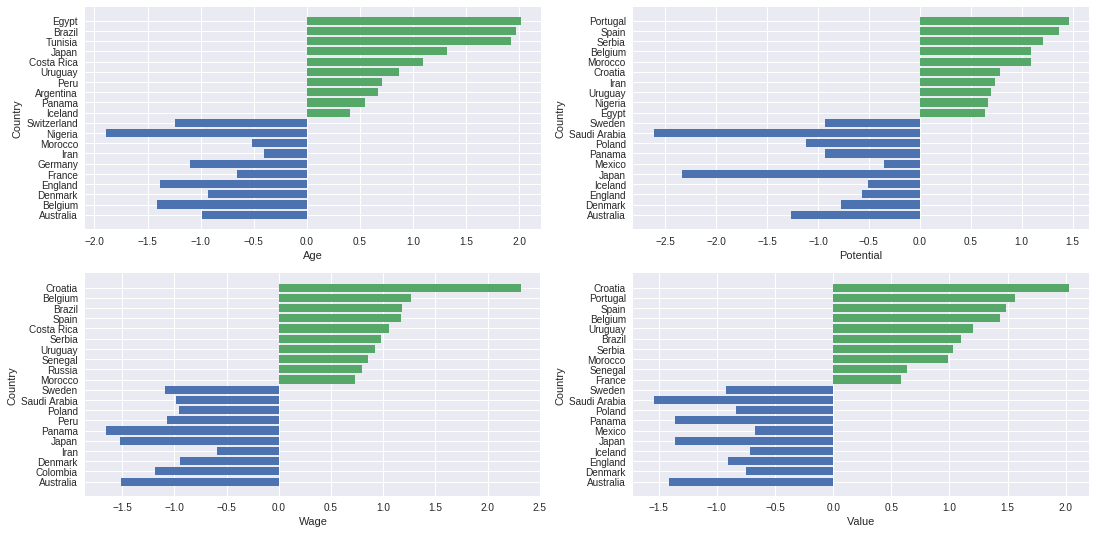

In [496]:


age=df1['Age']
Nationality=df1['Nationality']
playerval=df1.groupby('Club')['Value']
playernationality=df1.groupby('Nationality')['Age']


# n = pd.DataFrame(list(zip(df1['Value'],df1['Club'])))
age_high = result2.Age.sort_values()[:10]
age_low = result2.Age.sort_values()[-10:]

pot_high = result2.Potential.sort_values()[:10]
pot_low = result2.Potential.sort_values()[-10:]

wage_high = result2.Wage.sort_values()[:10]
wage_low = result2.Wage.sort_values()[-10:]

value_high = result2.Value.sort_values()[:10]
value_low = result2.Value.sort_values()[-10:]


plt.figure(figsize = [18,9])
plt.subplot(2,2,1)
agedist=plt.barh(age_high.index,age_high,align='center')
agedist=plt.barh(age_low.index,age_low,align='center')
plt.xlabel('Age')
plt.ylabel('Country')
plt.subplot(2,2,2)
agedist=plt.barh(pot_high.index,pot_high,align='center')
agedist=plt.barh(pot_low.index,pot_low,align='center')
plt.xlabel('Potential')
plt.ylabel('Country')
plt.subplot(2,2,3)
agedist=plt.barh(wage_high.index,wage_high,align='center')
agedist=plt.barh(wage_low.index,wage_low,align='center')
plt.xlabel('Wage')
plt.ylabel('Country')
plt.subplot(2,2,4)
agedist=plt.barh(value_high.index,value_high,align='center')
agedist=plt.barh(value_low.index,value_low,align='center')
plt.xlabel('Value')
plt.ylabel('Country')




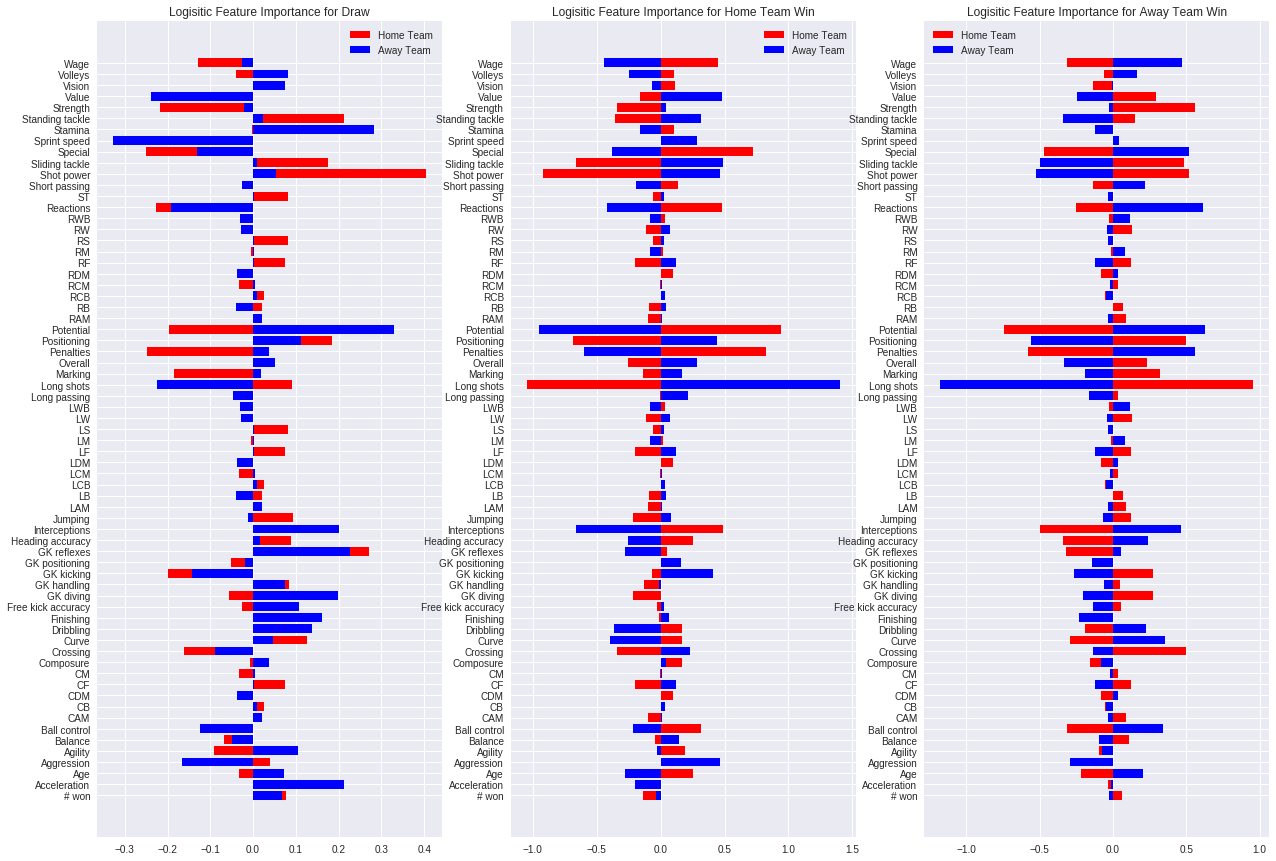

In [500]:
plt.figure(figsize = [21,15])
plt.subplot(1,3,1)
plt.title('Logisitic Feature Importance for Draw')
plt.barh(result2.columns,reg2.coef_[0,:67],color='r')
plt.barh(result2.columns,reg2.coef_[0,67:],color='b')
plt.legend(['Home Team','Away Team'])
plt.subplot(1,3,2)
plt.title('Logisitic Feature Importance for Home Team Win')
plt.barh(result2.columns,reg2.coef_[1,:67],color='r')
plt.barh(result2.columns,reg2.coef_[1,67:],color='b')
plt.legend(['Home Team','Away Team'])
plt.subplot(1,3,3)
plt.title('Logisitic Feature Importance for Away Team Win')
plt.barh(result2.columns,reg2.coef_[2,:67],color='r')
plt.barh(result2.columns,reg2.coef_[2,67:],color='b')
plt.legend(['Home Team','Away Team'])


In [501]:
from scipy.stats import ttest_ind

pvalues = {'params':[],'pvalue':[]}
for param in result2.columns:
  for param1 in result2.columns:
    if param == param1:
      pass
    elif [param1,param] in pvalues['params']:
      pass
    else:
      result_ind = ttest_ind(result2[param],result2[param1])
      pvalues['params'].append([param,param1])
      pvalues['pvalue'].append(result_ind.pvalue)

df_ttest=pd.DataFrame(pvalues)

df_ttest[df_ttest['pvalue']>0.05]


      

,params,pvalue
0,"[# won, Acceleration]",1.0
1,"[# won, Age]",1.0
2,"[# won, Aggression]",1.0
3,"[# won, Agility]",1.0
4,"[# won, Balance]",1.0
5,"[# won, Ball control]",1.0
6,"[# won, CAM]",1.0
7,"[# won, CB]",1.0
8,"[# won, CDM]",1.0
9,"[# won, CF]",1.0


# DataFrame give by TF with wage data and team data 

# New Section

In [502]:
# sofifa player personal data

response = requests.get('https://drive.google.com/uc?export=download&id=1vH1cY_CR1x5ChVzaim9vJ6hg2UodTpvp')
#have to decode the bytes before it can be read by pandas into df
df3 = pd.read_csv(BytesIO(response.content),index_col=0)
df3=df3.drop(["Unnamed: 0.1"],axis=1)
df3.head()


,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special
0,20801,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,€95.5M,€565K,2228
1,158023,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€105M,€565K,2154
2,190871,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,€123M,€280K,2100
3,176580,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€97M,€510K,2291
4,167495,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,€61M,€230K,1493


In [503]:
df3.shape

(17981, 13)

In [504]:
# check for null values in data
df3.isnull().sum()

ID               0
Name             0
Age              0
Photo            0
Nationality      0
Flag             0
Overall          0
Potential        0
Club           248
Club Logo        0
Value            0
Wage             0
Special          0
dtype: int64

In [505]:
df3_clean=df3.drop(["Photo","Flag","Club Logo"],axis=1)
df3_clean.head()

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special
0,20801,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,€95.5M,€565K,2228
1,158023,L. Messi,30,Argentina,93,93,FC Barcelona,€105M,€565K,2154
2,190871,Neymar,25,Brazil,92,94,Paris Saint-Germain,€123M,€280K,2100
3,176580,L. Suárez,30,Uruguay,92,92,FC Barcelona,€97M,€510K,2291
4,167495,M. Neuer,31,Germany,92,92,FC Bayern Munich,€61M,€230K,1493


In [0]:
df3_clean['Value'] = df3_clean['Value'].str.replace('€', '')
df3_clean['Wage']=df3_clean['Wage'].str.replace('€','')

 
#parse string for millions and thousands to numeric values
def parseValueColumn(strVal):
    if 'M' in strVal:
        return int(float(strVal.replace('M', '')) * 1000000)
    elif 'K' in strVal:
        return int(float(strVal.replace('K', '')) * 1000)
    else:
        return int(strVal)   
#parse string for thousands to numeric values 
def parseWageColumn(strVal):
  if 'K' in strVal:
    return int(float(strVal.replace('K', '')) * 1000)
  else:
    return int(strVal)   
 
df3_clean['Value'] = df3_clean['Value'].apply(lambda x: parseValueColumn(x))
df3_clean['Wage']=df3_clean['Wage'].apply(lambda x: parseWageColumn(x))

In [507]:
df3_clean.head()

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special
0,20801,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,95500000,565000,2228
1,158023,L. Messi,30,Argentina,93,93,FC Barcelona,105000000,565000,2154
2,190871,Neymar,25,Brazil,92,94,Paris Saint-Germain,123000000,280000,2100
3,176580,L. Suárez,30,Uruguay,92,92,FC Barcelona,97000000,510000,2291
4,167495,M. Neuer,31,Germany,92,92,FC Bayern Munich,61000000,230000,1493


In [508]:
df3_clean = df3_clean.rename(columns={'Nationality':'country'})
df3_clean
df3_pivot = pd.pivot_table(df3_clean,index='country',aggfunc='mean')
df3_pivot['country']=df3_pivot.index
df3_pivot.head()


,Age,ID,Overall,Potential,Special,Value,Wage,country
country,,,,,,,,
Afghanistan,22.000000,232622.333333,56.333333,66.333333,1499.666667,2.300000e+05,2000.000000,Afghanistan
Albania,24.685714,208863.714286,66.257143,70.771429,1616.800000,2.116714e+06,10514.285714,Albania
Algeria,26.543860,202615.947368,70.947368,73.736842,1743.561404,4.884386e+06,17982.456140,Algeria
Angola,25.600000,210990.666667,68.266667,72.333333,1671.600000,2.473000e+06,9000.000000,Angola
Antigua & Barbuda,22.400000,214448.000000,58.600000,66.800000,1516.600000,3.080000e+05,2600.000000,Antigua & Barbuda


In [509]:
df3_pivot.describe()

,Age,ID,Overall,Potential,Special,Value,Wage
count,165.000000,165.000000,165.000000,165.000000,165.000000,1.650000e+02,165.000000
mean,25.531354,209281.741913,66.094792,70.448119,1607.098908,1.844789e+06,9137.968733
std,2.377512,14469.324610,3.595767,3.041127,125.513368,1.379240e+06,5924.764130
min,17.000000,148684.000000,54.000000,58.000000,845.000000,0.000000e+00,0.000000
25%,24.418367,204505.000000,64.000000,68.851632,1557.500000,7.580000e+05,4333.333333
50%,25.272966,209153.054054,66.750000,70.888889,1620.636269,1.475000e+06,8056.000000
75%,26.666667,216003.000000,68.500000,72.760000,1672.562500,2.770000e+06,13000.000000
max,35.000000,240805.000000,73.000000,77.000000,1868.000000,7.903333e+06,26666.666667


# Data given from TF about players positions with their id

In [510]:
# sofifa player playing position data

response = requests.get('https://drive.google.com/uc?export=download&id=1QL43193ev8I66MXp3iJxwiC-jj7AGBMo')
df4 = pd.read_csv(BytesIO(response.content),index_col=0)
df4.head()

,CAM,CB,CDM,CF,CM,ID,LAM,LB,LCB,LCM,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,89.0,53.0,62.0,91.0,82.0,20801,89.0,61.0,53.0,82.0,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,92.0,45.0,59.0,92.0,84.0,158023,92.0,57.0,45.0,84.0,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,88.0,46.0,59.0,88.0,79.0,190871,88.0,59.0,46.0,79.0,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,87.0,58.0,65.0,88.0,80.0,176580,87.0,64.0,58.0,80.0,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,NaN,NaN,NaN,NaN,NaN,167495,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [511]:
df4.describe()

,CAM,CB,CDM,CF,CM,ID,LAM,LB,LCB,LCM,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
count,15952.000000,15952.000000,15952.000000,15952.000000,15952.000000,17981.000000,15952.000000,15952.000000,15952.000000,15952.000000,...,15952.000000,15952.000000,15952.000000,15952.000000,15952.000000,15952.000000,15952.000000,15952.000000,15952.000000,15952.000000
mean,59.251755,55.550464,56.865283,59.030028,58.506833,207658.710138,59.251755,56.979689,55.550464,58.506833,...,56.979689,55.550464,58.506833,56.865283,59.030028,60.057736,58.204050,59.359265,57.698721,58.204050
std,9.880164,12.192579,10.310178,9.926988,8.888040,32291.667313,9.880164,9.791627,12.192579,8.888040,...,9.791627,12.192579,8.888040,10.310178,9.926988,9.349180,9.181392,9.978084,9.142825,9.181392
min,27.000000,25.000000,26.000000,27.000000,30.000000,16.000000,27.000000,30.000000,25.000000,30.000000,...,30.000000,25.000000,30.000000,26.000000,27.000000,28.000000,31.000000,26.000000,31.000000,31.000000
25%,53.000000,45.000000,49.000000,53.000000,53.000000,192622.000000,53.000000,50.000000,45.000000,53.000000,...,50.000000,45.000000,53.000000,49.000000,53.000000,54.000000,52.000000,53.000000,51.000000,52.000000
50%,60.000000,57.000000,58.000000,60.000000,59.000000,214057.000000,60.000000,58.000000,57.000000,59.000000,...,58.000000,57.000000,59.000000,58.000000,60.000000,61.000000,59.000000,60.000000,58.000000,59.000000
75%,66.000000,65.000000,65.000000,66.000000,65.000000,231448.000000,66.000000,64.000000,65.000000,65.000000,...,64.000000,65.000000,65.000000,65.000000,66.000000,67.000000,65.000000,66.000000,64.000000,65.000000
max,92.000000,87.000000,85.000000,92.000000,87.000000,241219.000000,92.000000,84.000000,87.000000,87.000000,...,84.000000,87.000000,87.000000,85.000000,92.000000,90.000000,92.000000,91.000000,84.000000,92.000000


In [512]:
df4.shape

(17981, 28)

In [513]:
df4.columns

Index(['CAM', 'CB', 'CDM', 'CF', 'CM', 'ID', 'LAM', 'LB', 'LCB', 'LCM', 'LDM',
       'LF', 'LM', 'LS', 'LW', 'LWB', 'Preferred Positions', 'RAM', 'RB',
       'RCB', 'RCM', 'RDM', 'RF', 'RM', 'RS', 'RW', 'RWB', 'ST'],
      dtype='object')

Text(0.5,1,'The 10 most preferred positions by players')

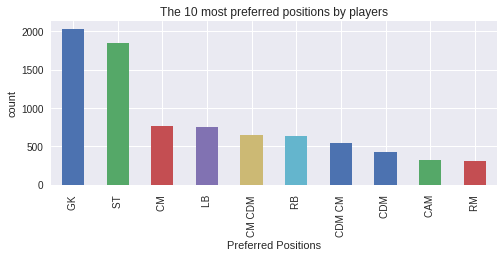

In [514]:
# plt.hist(df4['Preferred Positions'].value_counts())
plt.figure(figsize=(8,3))
 
# sns.countplot(df4['Preferred Positions'],palette="Set2")

df4['Preferred Positions'].value_counts()[1:11].plot(kind='bar')
plt.xlabel("Preferred Positions")
plt.ylabel("count")
plt.title("The 10 most preferred positions by players")
